### **Use this Notebook on Google Colab Free GPU**
Go to Google Drive, upload this notebook and dataset folders. Rigth click notebook, choose **Open with -> Google Colab**
<br>
To activate GPU in Colab, go to **Runtime -> Change Runtime Type**. Under **Hardware accelerator** choose **GPU**

### Connect to Google Drive to access Dataset

In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd '/content/drive/My Drive/COVID Detection'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
/content/drive/My Drive/COVID Detection


### Import all dependencies

In [1]:
from __future__ import print_function, division
from builtins import range, input

from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, AveragePooling2D, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.applications import Xception
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix, roc_curve
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import cv2
from glob import glob

### Define Few Parameters

In [2]:
#define size to which images are to be resized
IMAGE_SIZE = [224, 224] # feel free to change depending on dataset

# training config:
epochs = 500
batch_size = 32

#define paths
covid_path = '/Users/devarshiwadadkar/Documents/COVIDEDI/data/chest/Chest_COVID'
noncovid_path = '/Users/devarshiwadadkar/Documents/COVIDEDI/data/chest/Chest_NonCOVID'

# Use glob to grab images from path .jpg or jpeg
covid_files = glob(covid_path + '/*')
noncovid_files = glob(noncovid_path + '/*')

### Fetch Images and Class Labels from Files (This might take a while)

In [3]:
# Preparing Labels
covid_labels = []
noncovid_labels = []

covid_images=[]
noncovid_images=[]
covid_name=[]
noncovid_name=[]

import cv2 

for i in range(len(covid_files)):
  image = cv2.imread(covid_files[i])
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image = cv2.resize(image,(224,224))
  covid_images.append(image)
  covid_labels.append('Chest_COVID')
  covid_name.append([image,covid_files[i]])
for i in range(len(noncovid_files)):
  image = cv2.imread(noncovid_files[i])
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image = cv2.resize(image,(224,224))
  noncovid_images.append(image)
  noncovid_labels.append('Chest_NonCOVID')
  noncovid_name.append([image,noncovid_files[i]])

### Visualize First 40 Images from Data set

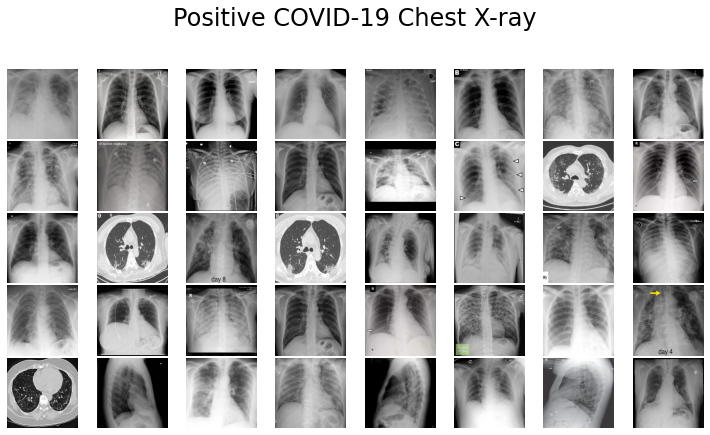

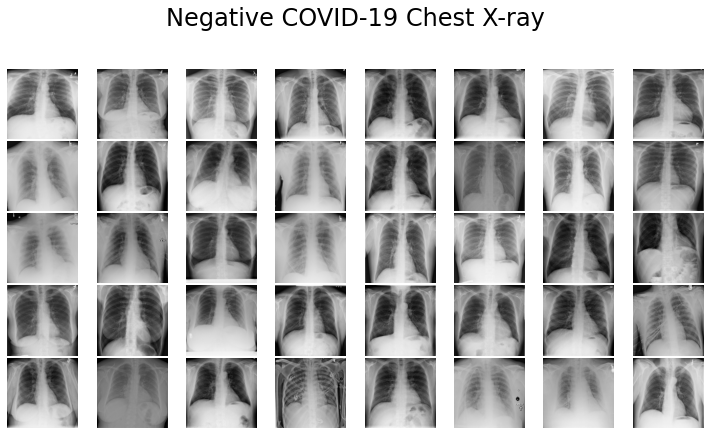

In [4]:
# look at a random image for fun
def plot_images(images, title):
    nrows, ncols = 5, 8
    figsize = [10, 6]

    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize, facecolor=(1, 1, 1))

    for i, axi in enumerate(ax.flat):
        axi.imshow(images[i])
        axi.set_axis_off()

    plt.suptitle(title, fontsize=24)
    plt.tight_layout(pad=0.2, rect=[0, 0, 1, 0.9])
    plt.show()
plot_images(covid_images, 'Positive COVID-19 Chest X-ray')
plot_images(noncovid_images, 'Negative COVID-19 Chest X-ray')

### **Normalization**
#### Model takes images in the form of array of pixels. Hence convert into array and *normalize*

In [5]:
# normalize to interval of [0,1]
covid_images = np.array(covid_images) / 255
noncovid_images = np.array(noncovid_images) / 255

### **Train Test Split**

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.utils import to_categorical

# split into training and testing
covid_x_train, covid_x_test, covid_y_train, covid_y_test = train_test_split(
    covid_images, covid_labels, test_size=0.2)
noncovid_x_train, noncovid_x_test, noncovid_y_train, noncovid_y_test = train_test_split(
    noncovid_images, noncovid_labels, test_size=0.2)


X_train = np.concatenate((noncovid_x_train, covid_x_train), axis=0)
X_test = np.concatenate((noncovid_x_test, covid_x_test), axis=0)
y_train = np.concatenate((noncovid_y_train, covid_y_train), axis=0)
y_test = np.concatenate((noncovid_y_test, covid_y_test), axis=0)

# make labels into categories - either 0 or 1
y_train = LabelBinarizer().fit_transform(y_train)
y_train = to_categorical(y_train)

y_test = LabelBinarizer().fit_transform(y_test)
y_test = to_categorical(y_test,dtype ="int64")

### Visualize a few images from Training and Test sets

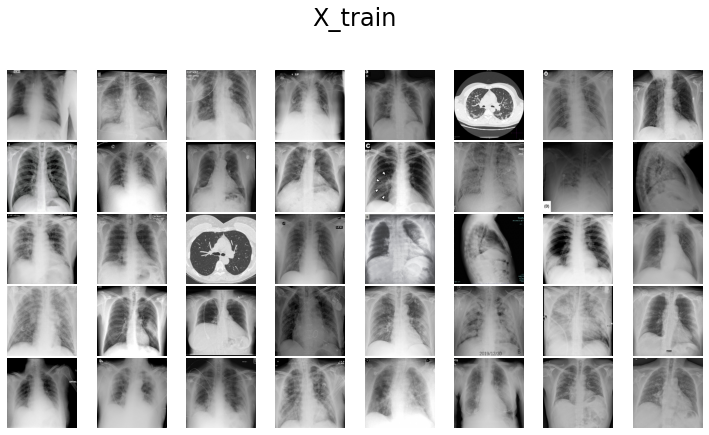

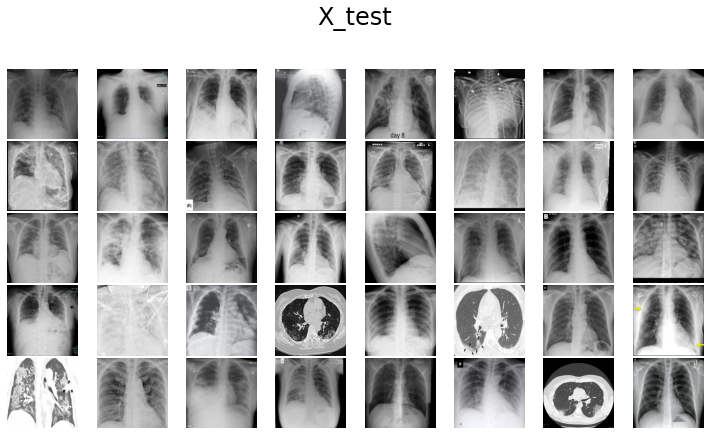

In [7]:
plot_images(covid_x_train, 'X_train')
plot_images(covid_x_test, 'X_test')
# y_train and y_test contain class lables 0 and 1 representing COVID and NonCOVID for X_train and X_test

### **Building and Visualizing model**

In [9]:
xception = Xception(weights="imagenet", include_top=False,
    input_tensor=Input(shape=(224, 224, 3)))

outputs = xception.output
outputs = Flatten(name="flatten")(outputs)
outputs = Dropout(0.5)(outputs)
outputs = Dense(2, activation="softmax")(outputs)

model = Model(inputs=xception.input, outputs=outputs)

for layer in xception.layers:
    layer.trainable = False

model.compile(
        loss='categorical_crossentropy', 
        optimizer='adam', 
        metrics=['accuracy']
)

83689472/83683744 [==============================] - 1s 0us/step


In [10]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 111, 111, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 111, 111, 32) 0           block1_conv1_bn[0][0]            
______________________________________________________________________________________________

### **Image Augmentation**
To train on images at different positions, angles, flips, etc

In [ ]:
train_aug = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

### **Training the model**

In [19]:
history = model.fit(train_aug.flow(X_train, y_train, batch_size=32),
                    validation_data=(X_test, y_test),
                    validation_steps=len(X_test) / 32,
                    steps_per_epoch=len(X_train) / 32,
                    epochs=500)

Epoch 1/500
24/23 [==============================] - 12s 505ms/step - loss: 0.6387 - accuracy: 0.9561 - val_loss: 1.2367 - val_accuracy: 0.9468
Epoch 2/500
24/23 [==============================] - 11s 439ms/step - loss: 0.9452 - accuracy: 0.9481 - val_loss: 0.9714 - val_accuracy: 0.9521
Epoch 3/500
24/23 [==============================] - 10s 427ms/step - loss: 0.8207 - accuracy: 0.9441 - val_loss: 2.3721 - val_accuracy: 0.9202
Epoch 4/500
24/23 [==============================] - 11s 441ms/step - loss: 1.6856 - accuracy: 0.9189 - val_loss: 1.5488 - val_accuracy: 0.9415
Epoch 5/500
24/23 [==============================] - 10s 434ms/step - loss: 0.9638 - accuracy: 0.9561 - val_loss: 0.8868 - val_accuracy: 0.9574
Epoch 6/500
24/23 [==============================] - 10s 433ms/step - loss: 0.5390 - accuracy: 0.9628 - val_loss: 0.8111 - val_accuracy: 0.9521
Epoch 7/500
24/23 [==============================] - 10s 435ms/step - loss: 0.7383 - accuracy: 0.9601 - val_loss: 0.8385 - val_accuracy:

In [ ]:
model.save('xception_chest.h5')

In [ ]:
model.save_weights('xceptionweights_chest.hdf5')

In [8]:
model = load_model('/Users/devarshiwadadkar/Documents/COVIDEDI/models/xception_chest.h5')

2022-01-21 10:01:04.780345: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-01-21 10:01:04.782294: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### **Making Predicions**

In [9]:
y_pred = model.predict(X_test, batch_size=batch_size)

2022-01-21 10:02:05.441924: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)


In [10]:
prediction=y_pred
y_p=[]

for index, probability in enumerate(prediction):
  if probability[1] > 0.5:
        #plt.title('%.2f' % (probability[1]*100) + '% COVID')
        y_p.append([0, 1])
        
  else:
        #plt.title('%.2f' % ((1-probability[1])*100) + '% NonCOVID')
        y_p.append([1, 0])
  #plt.imshow(X_test[index])
 # plt.show()

In [11]:
yarray=np.array(y_p)

In [12]:
incorrect=[]
for x in range(len(y_test)):
    if(any(y_test[x]!=yarray[x])):
        incorrect.append(x)
        print(x)

73
120
158
168


In [13]:
imagearr=[]
test=[]
for x in incorrect:
    imagearr.append(np.array(X_test[x]) * 255)
    test.append(X_test[x])
    #print(X_test[x]*255)

In [14]:
arr=imagearr
for i in range(0, len(arr)):    
    for j in range(i+1, len(arr)):    
        if(np.all(arr[i] == arr[j])):    
         print(arr[j])

In [15]:
temp=np.array(imagearr)

In [16]:
namearr=temp.astype(np.uint8)

In [17]:
print(len(covid_name))

435


In [18]:
for x in range(435):
    for y in range(len(imagearr)):
            #print(y,x)
        #print(X_test[y])
        #print(covid_name[x][0])
        if(np.all(test[y]==(covid_name[x][0])/255)):
            print(covid_name[x][1])

/Users/devarshiwadadkar/Documents/COVIDEDI/data/chest/Chest_COVID/right-upper-lobe-pneumonia-9-PA.jpg
/Users/devarshiwadadkar/Documents/COVIDEDI/data/chest/Chest_COVID/kjr-21-e24-g003-l-a.jpg
/Users/devarshiwadadkar/Documents/COVIDEDI/data/chest/Chest_COVID/CD50BA96-6982-4C80-AE7B-5F67ACDBFA56.jpeg


### Visulaizing First 10 predictions

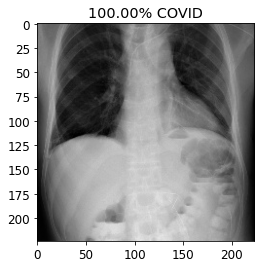

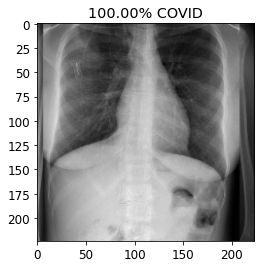

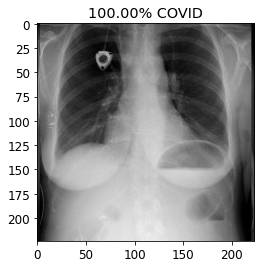

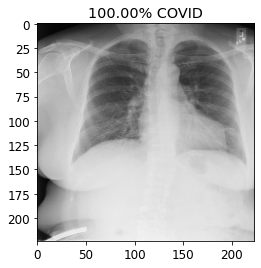

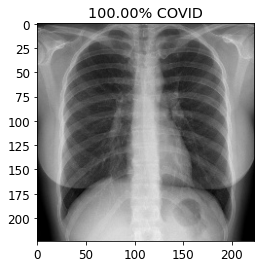

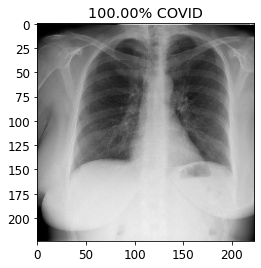

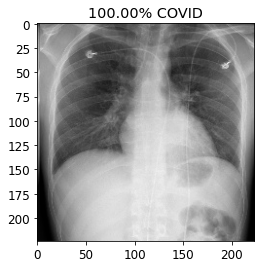

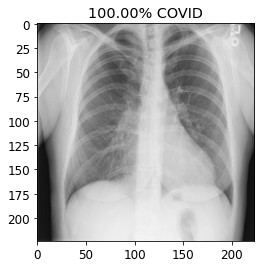

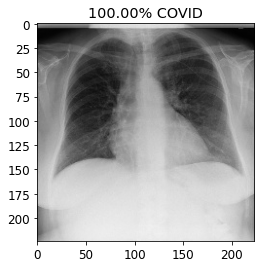

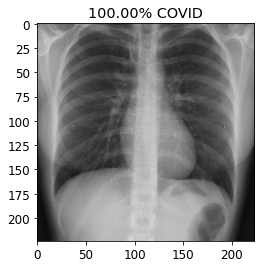

In [39]:
prediction=y_pred[0:10]
for index, probability in enumerate(prediction):
  if probability[1] > 0.5:
        plt.title('%.2f' % (probability[1]*100) + '% COVID')
  else:
        plt.title('%.2f' % ((1-probability[1])*100) + '% NonCOVID')
  plt.imshow(X_test[index])
  plt.show()

In [ ]:
# Convert to Binary classes
y_pred_bin = np.argmax(y_pred, axis=1)
y_test_bin = np.argmax(y_test, axis=1)

### Plot ROC Curve

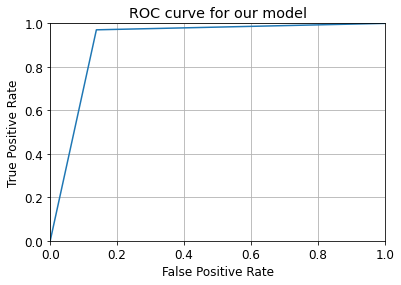

In [26]:
fpr, tpr, thresholds = roc_curve(y_test_bin, y_pred_bin)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for our model')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)

### Plot Confusion Matrix

Confusion Matrix without Normalization


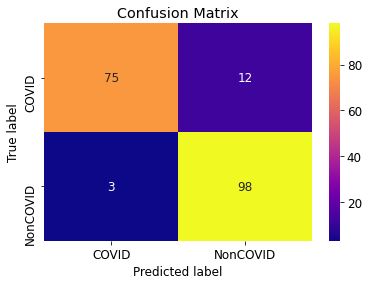

Confusion Matrix with Normalized Values


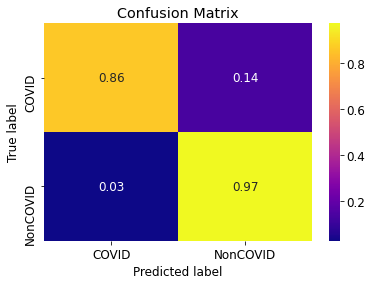

In [27]:
def plot_confusion_matrix(normalize):
  classes = ['COVID','NonCOVID']
  tick_marks = [0.5,1.5]
  cn = confusion_matrix(y_test_bin, y_pred_bin,normalize=normalize)
  sns.heatmap(cn,cmap='plasma',annot=True)
  plt.xticks(tick_marks, classes)
  plt.yticks(tick_marks, classes)
  plt.title('Confusion Matrix')
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

print('Confusion Matrix without Normalization')
plot_confusion_matrix(normalize=None)

print('Confusion Matrix with Normalized Values')
plot_confusion_matrix(normalize='true')

### **Classification Report**

In [28]:
from sklearn.metrics import classification_report
print(classification_report(y_test_bin, y_pred_bin))

              precision    recall  f1-score   support

           0       0.96      0.86      0.91        87
           1       0.89      0.97      0.93       101

    accuracy                           0.92       188
   macro avg       0.93      0.92      0.92       188
weighted avg       0.92      0.92      0.92       188



### **Accuracy and Loss Plots**

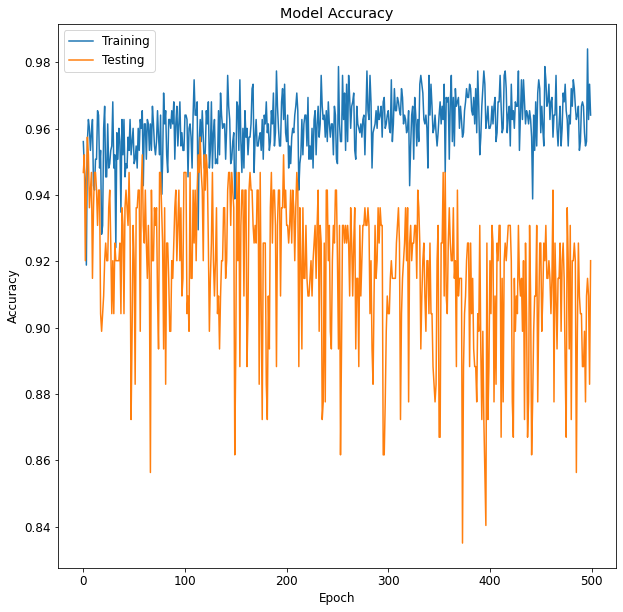

In [29]:
plt.figure(figsize=(10,10))

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

plt.legend(['Training', 'Testing'])
plt.savefig('xception_chest_accuracy.png')
plt.show()


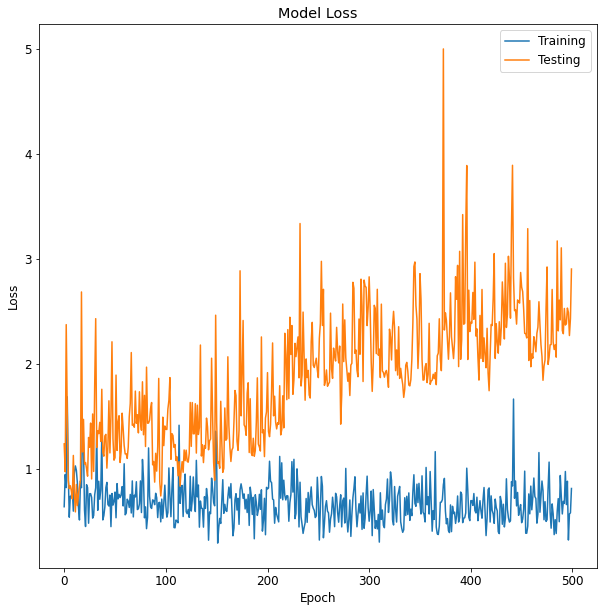

In [30]:
plt.figure(figsize=(10,10))

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')

plt.legend(['Training', 'Testing'])
plt.savefig('xception_chest_loss.png')
plt.show()